In [1]:
import sys
sys.path.append('/scratch/gf332/Misc/BVAE/code')

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from tqdm import tqdm

from bnn import DummyBNN
from adaptive_sghmc import AdaptiveSGHMC
from sghmc import SGHMC

%matplotlib inline

tfd = tfp.distributions
tfl = tf.keras.layers

paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)

#plt.rc("text", usetex=True)
plt.rc("font", size=32.0, family="serif")
plt.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]

In [2]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
def f(x):
    return np.sinc(x * 10. - 5.)

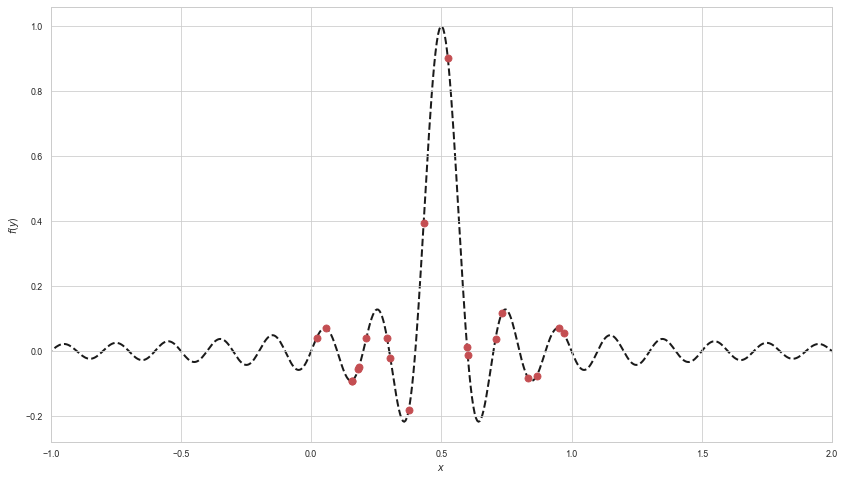

In [4]:
rng = np.random.RandomState(42)

num_points = 20

x = rng.rand(num_points).astype(np.float32)
y = f(x)

grid = np.linspace(-2., 3., 1000).astype(np.float32)
fvals = f(grid)

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(grid, fvals, linestyle='--', c='k', zorder=0)
ax.scatter(x, y, marker='o', c='r', zorder=1, s=50)

ax.set_xlim([-1., 2.])
ax.set_xlabel("$x$")
ax.set_ylabel("$f(y)$")

plt.show()

In [5]:
bnn = DummyBNN()
bnn.build(input_shape=(None, 1))

In [6]:
@tf.function
def train_step(model, batch, labels):

    with tf.GradientTape() as tape:
        
        data_size = tf.cast(num_points, tf.float32)
        
        pred = model(batch)
        
        likelihood = tfd.Normal(loc=pred, scale=tf.exp(0.5 * model.likelihood_log_var))
        log_likelihood = tf.reduce_mean(likelihood.log_prob(labels))
        
        var_prior_log_prob = model.var_prior.log_prob(tf.exp(model.likelihood_log_var)) / data_size
        
        weight_prior_log_prob = model.weight_prior_log_prob() / data_size
        
        loss = -(log_likelihood + weight_prior_log_prob + var_prior_log_prob)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return pred, log_likelihood, var_prior_log_prob, weight_prior_log_prob

In [7]:
batch_size = num_points
iterations = 20000
keep_every = 50
burnin = 3000
learning_rate = 3e-2
momentum_decay = 0.05

log_every = 1000

x_mean, x_var = tf.nn.moments(tf.convert_to_tensor(x), axes=[0])
x_std = tf.sqrt(x_var)
y_mean, y_var = tf.nn.moments(tf.convert_to_tensor(y), axes=[0])
y_std = tf.sqrt(y_var)

x_normalized = (x - x_mean) / x_std
y_normalized = (y - y_mean) / y_std

ds = tf.data.Dataset.from_tensor_slices((x_normalized[:, None], y_normalized[:, None]))
ds = ds.shuffle(500).repeat().batch(batch_size).prefetch(16)

optimizer = {
    "adaptive_sghmc": AdaptiveSGHMC(learning_rate=learning_rate,
                                    burnin=burnin,
                                    data_size=num_points,
                                    overestimation_rate=10000.,
                                    momentum_decay=momentum_decay),
    
    "sghmc": SGHMC(learning_rate=1e-6,
                   data_size=num_points,
                   momentum_decay=momentum_decay),
    
    "adam": tf.optimizers.Adam(learning_rate=1e-3),
}["adaptive_sghmc"]

In [8]:
weight_samples = []

i = 0

for batch, labels in tqdm(ds.take(iterations), total=iterations):

    i = i + 1
    
    # Resample scale hyperparameters every epoch

    pred, ll, vplp, wplp = train_step(bnn,
                                      batch, 
                                      labels)
    
    if i >= burnin and i % keep_every == 0:
        weight_samples.append(bnn.get_weights())
        
    if i % log_every == 0:
        mse = tf.reduce_mean(tf.math.squared_difference(pred, labels[:, None]))
        
        print(f"iteration {i}: "
              f"MSE: {mse}, "
              f"LL: {ll}, "
              f"weight prior LL: {wplp}, "
              f"var prior LL: {vplp}")

  0%|          | 1/20000 [00:02<12:54:23,  2.32s/it]

SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!


  6%|▌         | 1106/20000 [00:04<01:10, 268.08it/s]

iteration 1000: MSE: 1.8686484098434448, LL: -27.663198471069336, weight prior LL: -1.4695626497268677, var prior LL: -16.08095359802246


 10%|█         | 2079/20000 [00:06<00:34, 522.02it/s]

iteration 2000: MSE: 2.1653683185577393, LL: -11.116182327270508, weight prior LL: -1.7997287511825562, var prior LL: -15.995753288269043


 15%|█▌        | 3058/20000 [00:08<00:32, 522.70it/s]

iteration 3000: MSE: 2.0085904598236084, LL: -0.3678593039512634, weight prior LL: -2.4575459957122803, var prior LL: -15.336870193481445


 20%|██        | 4086/20000 [00:09<00:28, 556.03it/s]

iteration 4000: MSE: 1.9790111780166626, LL: 0.7913790941238403, weight prior LL: -1.9226915836334229, var prior LL: -13.753369331359863


 25%|██▌       | 5059/20000 [00:11<00:27, 551.48it/s]

iteration 5000: MSE: 2.000948190689087, LL: 1.6228281259536743, weight prior LL: -1.7726608514785767, var prior LL: -13.376349449157715


 30%|███       | 6082/20000 [00:13<00:25, 542.78it/s]

iteration 6000: MSE: 2.0106232166290283, LL: 0.5752679705619812, weight prior LL: -2.6897428035736084, var prior LL: -12.003759384155273


 35%|███▌      | 7098/20000 [00:15<00:24, 532.18it/s]

iteration 7000: MSE: 2.0033020973205566, LL: 1.109164834022522, weight prior LL: -3.5660502910614014, var prior LL: -11.444920539855957


 40%|████      | 8053/20000 [00:17<00:22, 536.79it/s]

iteration 8000: MSE: 1.8450722694396973, LL: -27.037450790405273, weight prior LL: -3.1343867778778076, var prior LL: -10.819692611694336


 45%|████▌     | 9081/20000 [00:18<00:19, 547.13it/s]

iteration 9000: MSE: 1.9954514503479004, LL: 1.7999080419540405, weight prior LL: -3.3689239025115967, var prior LL: -10.022805213928223


 50%|█████     | 10059/20000 [00:20<00:18, 544.64it/s]

iteration 10000: MSE: 1.9898974895477295, LL: 1.8048890829086304, weight prior LL: -3.870086669921875, var prior LL: -8.895415306091309


 55%|█████▌    | 11085/20000 [00:22<00:16, 550.98it/s]

iteration 11000: MSE: 1.970829725265503, LL: 1.8442280292510986, weight prior LL: -3.6840882301330566, var prior LL: -7.900213718414307


 60%|██████    | 12096/20000 [00:24<00:14, 543.09it/s]

iteration 12000: MSE: 2.0084140300750732, LL: 2.1517345905303955, weight prior LL: -5.069077968597412, var prior LL: -7.006921291351318


 65%|██████▌   | 13080/20000 [00:26<00:12, 571.64it/s]

iteration 13000: MSE: 2.0007214546203613, LL: 2.506371259689331, weight prior LL: -4.744613170623779, var prior LL: -6.210021495819092


 70%|███████   | 14099/20000 [00:27<00:10, 540.17it/s]

iteration 14000: MSE: 2.0048160552978516, LL: 2.010780096054077, weight prior LL: -5.308108806610107, var prior LL: -5.499135494232178


 75%|███████▌  | 15074/20000 [00:29<00:08, 559.09it/s]

iteration 15000: MSE: 1.9940118789672852, LL: 2.5308499336242676, weight prior LL: -6.58324670791626, var prior LL: -4.902774810791016


 81%|████████  | 16113/20000 [00:31<00:06, 562.49it/s]

iteration 16000: MSE: 2.0004324913024902, LL: 2.044124126434326, weight prior LL: -5.680267333984375, var prior LL: -4.324889659881592


 86%|████████▌ | 17133/20000 [00:33<00:04, 629.35it/s]

iteration 17000: MSE: 1.899656057357788, LL: -53.60167694091797, weight prior LL: -5.3721699714660645, var prior LL: -5.74600076675415


 90%|█████████ | 18092/20000 [00:34<00:03, 605.44it/s]

iteration 18000: MSE: 1.999549150466919, LL: -1.0517494678497314, weight prior LL: -5.472660064697266, var prior LL: -6.6521782875061035


 96%|█████████▌| 19127/20000 [00:36<00:01, 640.90it/s]

iteration 19000: MSE: 2.0195205211639404, LL: -1.2401561737060547, weight prior LL: -5.397000789642334, var prior LL: -6.2251129150390625


100%|██████████| 20000/20000 [00:37<00:00, 529.72it/s]

iteration 20000: MSE: 1.9726101160049438, LL: 1.5030443668365479, weight prior LL: -5.670374393463135, var prior LL: -5.619154930114746


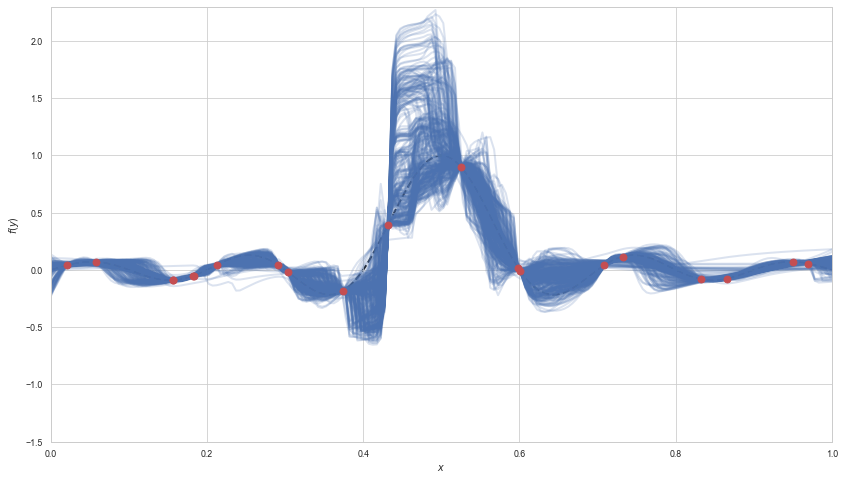

In [9]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14, 8))

all_preds = []

for weights in weight_samples[:]:
    
    bnn.set_weights(weights)
    
    pred = bnn((grid[:, None] - x_mean) / x_std).numpy()[:, 0]
    pred = y_std * pred + y_mean
    
    ax.plot(grid, pred, c='b', alpha=0.2, zorder=1)
    
    all_preds.append(pred)

all_preds = tf.stack(all_preds, axis=0)

ax.plot(grid, fvals, linestyle='--', c='k', zorder=0)
ax.scatter(x, y, marker='o', c='r', zorder=2, s=50)

ax.set_xlim([-0., 1.])
ax.set_ylim([-1.5, 2.3])
ax.set_xlabel("$x$")
ax.set_ylabel("$f(y)$")

plt.show()

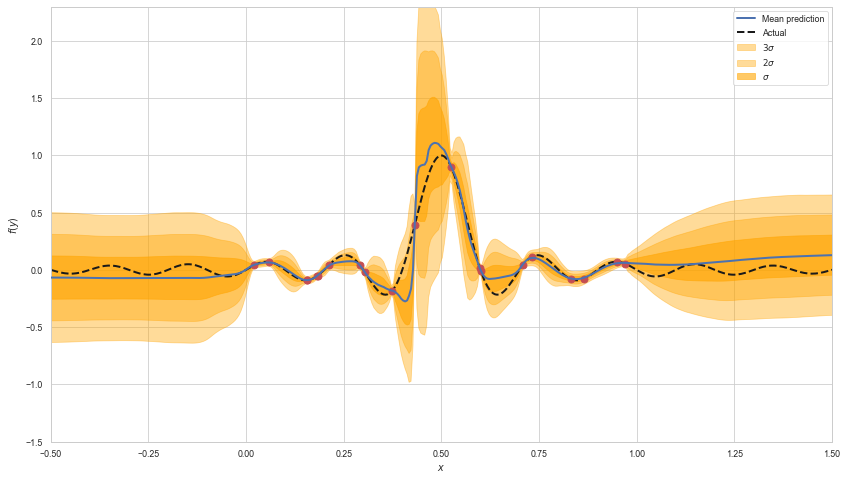

In [10]:
mean_pred, var_pred = tf.nn.moments(all_preds[30:, :], axes=[0])

fig, ax = plt.subplots(figsize=(14, 8))

std_pred = tf.sqrt(var_pred)

ax.plot(grid, mean_pred, linestyle='-', c='b', zorder=4, label="Mean prediction")
ax.fill_between(grid, 
                mean_pred + 3. * std_pred, 
                mean_pred - 3. * std_pred, 
                alpha=0.4, label="$3\sigma$", color='orange')

ax.fill_between(grid, 
                mean_pred + 2. * std_pred, 
                mean_pred - 2. * std_pred, 
                alpha=0.4, label="$2\sigma$", color='orange')

ax.fill_between(grid, 
                mean_pred + std_pred, 
                mean_pred - std_pred, 
                alpha=0.6, label="$\sigma$", color='orange')

ax.plot(grid, fvals, linestyle='--', c='k', zorder=2, label="Actual")
ax.scatter(x, y, marker='o', c='r', zorder=3, s=50)

ax.set_xlim([-0.5, 1.5])
ax.set_ylim([-1.5, 2.3])
ax.set_xlabel("$x$")
ax.set_ylabel("$f(y)$")

ax.legend()

plt.show()

In [11]:
bnn.likelihood_log_var

<tf.Variable 'likelihood_log_variance:0' shape=() dtype=float32, numpy=-7.6520953>